In [1]:
PROCESSES_COUNT = 30

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, endf_tools
import seaborn as sns
import openmc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    statepoint_number = run_settings["active_batch_count"] + run_settings["inactive_batch_count"]
    sp = openmc.StatePoint(f"{result_path}/statepoint.{statepoint_number}.h5")

    result = {
        "k-eff": sp.keff.nominal_value, 
        "k-eff-std": sp.keff.std_dev,  
        "result_path": result_path
    }

    result.update(run_settings)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

Importing...
Found 538 result folders
Loading data with 30 processes...


100%|██████████| 538/538 [00:09<00:00, 59.09it/s] 


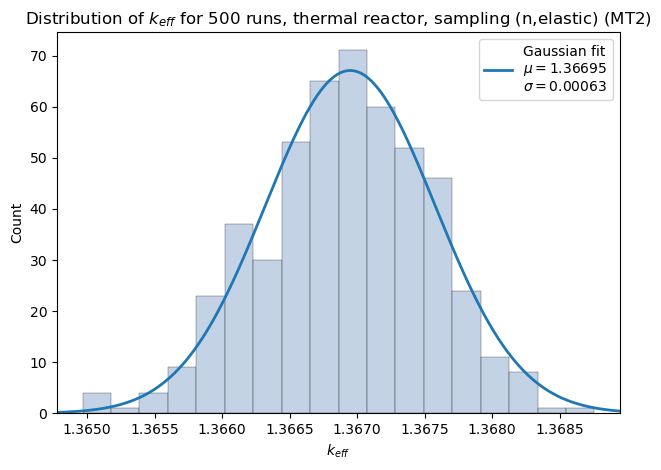

In [7]:
importlib.reload(plot_tools)

# PLOT SETTINGS:
FAST_REACTOR = False # True if epithermal, False if thermal
USE_SAMPLED_DATA = True
MT = 2

# for FAST_REACTOR in [True, False]:
#     for USE_SAMPLED_DATA in [True, False]:

NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

folder_name = f"plots-{NEUTRON_TEMP}-{SAMPLED_STRING}"
os.makedirs(folder_name, exist_ok=True)

def get_filename(plot_type: str, value: str):
    return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}-{SAMPLED_STRING}.pdf"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]
df = df[df["MT"] == MT]

if df.empty:
    raise Exception("No results found!")

df = data_tools.add_reactivity_to_df(df)

plt.figure()
fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                        fit_gaussian=True, decimals=5,
                                        title=f"Distribution of $k_{{eff}}$ for {len(df)} runs, {NEUTRON_TEMP.lower()} reactor, sampling {endf_tools.MT_to_label(MT, True)} (MT{MT})", x_label="$k_{eff}$", y_label="Count",
                                        filename=get_filename("heatmap", "distribution-k_eff"))

# plt.figure()
# fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
#                                         fit_gaussian=True, decimals=0,
#                                         title=fr"Distribution of $\rho$ for {len(df)} runs", x_label=r"$\rho$ [pcm]", y_label="Count",
#                                         filename=get_filename("heatmap", "distribution-rho"))

In [12]:
importlib.reload(plot_tools)

# TMC analysis
USE_SAMPLED_DATA = True

FAST_REACTOR = False # True if epithermal, False if thermal
MT = 2

NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
SAMPLED_STRING = "SAMPLED" if USE_SAMPLED_DATA else "NOT_SAMPLED"

# Create a dataframe from the results
df = pd.DataFrame(results)

# Filters
df = df[df["fast_reactor"] == FAST_REACTOR]
df = df[df["use_sampled_data"] == USE_SAMPLED_DATA]
df = df[df["MT"] == MT]

sigma_obs = np.std(df["k-eff"], ddof=1)
sigma2_obs = sigma_obs**2
sigma2_stat_mean = np.sum(df["k-eff-std"]**2) / len(df["k-eff-std"])
sigma_stat_mean = np.sqrt(sigma2_stat_mean)
sigma2_ND = sigma2_obs - sigma2_stat_mean
sigma_ND = np.sqrt(sigma2_ND)

k_eff_mean = np.mean(df["k-eff"])
R_sampled = sigma_obs / k_eff_mean
R_not_sampled = sigma_stat_mean / k_eff_mean
R_ND = sigma_ND / k_eff_mean

u_k = ufloat(k_eff_mean, sigma_ND)
u_rho = 1 - 1/u_k

print("TMC analysis v1")
print("===============")
print(f"{NEUTRON_TEMP}")
print(f"Sampling {endf_tools.MT_to_label(MT, True)} (MT{MT})")
print(f"Based on {len(df)} runs")
print(f" -- k_eff --")
print(f"k_eff: \t\t{k_eff_mean:.3f}")
# print(f"σ2_obs: \t{sigma2_obs:.2e}")
print(f"σ_obs: \t\t{sigma_obs:.2e}")
# print(f"σ2_stat_mean: \t{sigma2_stat_mean:.2e}")
print(f"σ_stat_mean: \t{sigma_stat_mean:.2e}")
# print(f"σ2_ND: \t\t{sigma2_ND:.2e}")
print(f"σ_ND: \t\t{sigma_ND:.2e}")
print(f"R_sampled: \t{(R_sampled*1e5):.1f} pcm")
print(f"R_not_sampled: \t{(R_not_sampled*1e5):.1f} pcm")
print(f"R_ND: \t\t{(R_ND*1e5):.1f} pcm")
print(f" -- ρ --")
print(f"ρ: \t\t{(u_rho.nominal_value*1e5):.1f} pcm")
print(f"ρ-std: \t\t{(u_rho.std_dev*1e5):.1f} pcm")


TMC analysis v1
THERMAL
Sampling (n,elastic) (MT2)
Based on 500 runs
 -- k_eff --
k_eff: 		1.367
σ_obs: 		6.20e-04
σ_stat_mean: 	3.15e-04
σ_ND: 		5.34e-04
R_sampled: 	45.4 pcm
R_not_sampled: 	23.1 pcm
R_ND: 		39.1 pcm
 -- ρ --
ρ: 		26842.2 pcm
ρ-std: 		28.6 pcm


In [ ]:
raise Exception("STOP") # Not doing v2 analysis for R11
# # 26 feb 2023 - correct TMC analysis
# importlib.reload(plot_tools)

# # TMC analysis

# FAST_REACTOR = False # True if epithermal, False if thermal

# NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"

# # Create a dataframe from the results
# df = pd.DataFrame(results)

# # Filters
# df = df[df["fast_reactor"] == FAST_REACTOR]
# df = df[df["use_sampled_data"] == True]

# plt.figure()
# fig_sampled, popt_sampled, pcov_sampled = plot_tools.plot_histogram_from_df(df=df[df["use_sampled_data"] == True], data_key="k-eff", 
#                                         fit_gaussian=True, decimals=5,
#                                         title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count")

# # Create a dataframe from the results
# df = pd.DataFrame(results)

# # Filters
# df = df[df["fast_reactor"] == FAST_REACTOR]
# df = df[df["use_sampled_data"] == False]

# plt.figure()
# fig_not_sampled, popt_not_sampled, pcov_not_sampled = plot_tools.plot_histogram_from_df(df=df[df["use_sampled_data"] == False], data_key="k-eff", 
#                                         fit_gaussian=True, decimals=5,
#                                         title=f"Distribution of $k_{{eff}}$ for {len(df)} runs", x_label="$k_{eff}$", y_label="Count")



# # Create a dataframe from the results
# df = pd.DataFrame(results)

# # Filters
# df = df[df["fast_reactor"] == FAST_REACTOR]

# plt.figure()
# fig_combined, popts_combined, pcovs_combined = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
#                                         fit_gaussian=True, decimals=5,
#                                         title=f"Distribution of $k_{{eff}}$ for $n={len(df)//2}$ runs, {NEUTRON_TEMP.lower()} reactor", x_label="$k_{eff}$", y_label="Count",
#                                         hue="use_sampled_data", hue_order=[1,0], hue_labels=["Sampled", "Not sampled"],
#                                         filename=f"combined_{NEUTRON_TEMP}.pdf")

# σ_sampled = np.abs(popts_combined[1][2])
# σ_not_sampled = np.abs(popts_combined[0][2])
# σ_ND = np.sqrt(σ_sampled**2 - σ_not_sampled**2)
# k_eff_mean = np.mean(df["k-eff"])
# R_sampled = σ_sampled / k_eff_mean
# R_not_sampled = σ_not_sampled / k_eff_mean
# R_ND = σ_ND / k_eff_mean

# u_k = ufloat(k_eff_mean, σ_ND)
# u_rho = 1 - 1/u_k

# print("TMC analysis v2")
# print("===============")
# print(f"{NEUTRON_TEMP}")
# print(f"Based on {len(df)} runs")
# print(f" -- k_eff --")
# print(f"k_eff: \t\t{k_eff_mean:.3f}")
# print(f"σ_sampled: \t{σ_sampled:.2e}")
# print(f"σ_not_sampled: \t{σ_not_sampled:.2e}")
# print(f"σ_ND: \t\t{σ_ND:.2e}")
# print(f"R_sampled: \t{(R_sampled*1e5):.1f} pcm")
# print(f"R_not_sampled: \t{(R_not_sampled*1e5):.1f} pcm")
# print(f"R_ND: \t\t{(R_ND*1e5):.1f} pcm")
# print(f" -- ρ --")
# print(f"ρ: \t\t{(u_rho.nominal_value*1e5):.1f} pcm")
# print(f"ρ-std: \t\t{(u_rho.std_dev*1e5):.1f} pcm")
